# Imports



In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from functools import partial

from tensorflow.keras.applications import vgg19

from tensorflow.keras.layers import Dense,Conv2D,Conv2DTranspose,BatchNormalization,Input,ReLU,Add,Lambda,LeakyReLU,Flatten,Activation
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.models import Model
from tensorflow import Tensor
import tensorflow as tf
import tensorflow_datasets as tfds
import keras

import cv2

In [ ]:
autotune = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [256, 256]
BATCH_SIZE=16

orig_img_size = (286, 286)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1

In [ ]:
# Load the horse-zebra dataset using tensorflow-datasets.
dataset, _ = tfds.load("cycle_gan/cezanne2photo", with_info=True, as_supervised=True)
train_cezanne, train_photo = dataset["trainA"], dataset["trainB"]
test_cezanne, test_photo = dataset["testA"], dataset["testB"]

# Define the standard image size.





def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img, label):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img, label):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

In [ ]:

# Apply the preprocessing operations to the training data
train_photo = (
    train_photo.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_cezanne = (
    train_cezanne.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

# Apply the preprocessing operations to the test data
test_photo = (
    test_photo.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_cezanne = (
    test_cezanne.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

# GENERATEUR

In [ ]:
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def residual_block(x: Tensor) -> Tensor:
  initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02, seed=None)
  x_0=x
  x = tf.pad(x_0, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
  y = Conv2D(kernel_size=(3,3),strides= (1,1),filters=256,padding="valid", use_bias=False,kernel_initializer=initializer)(x)
  y = InstanceNormalization(gamma_initializer=gamma_initializer)(y)
  y = ReLU()(y)

  y = tf.pad(y, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
  y = Conv2D(kernel_size=(3,3),strides=(1,1),filters=256,padding="valid", use_bias=False,kernel_initializer=initializer)(y)
  y = InstanceNormalization(gamma_initializer=gamma_initializer)(y)

  out = Add()([x_0,y])
  return out

In [ ]:
def create_generator():
  inputs = Input(shape=(256, 256, 3))
  initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02, seed=None)
  ## padding 
  pad= tf.pad(inputs, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
  ## C7s1-64
  layer_1 = Conv2D(filters=64,kernel_size=(7,7),kernel_initializer=initializer,use_bias=False)(pad)
  layer_1 = InstanceNormalization(gamma_initializer=gamma_initializer)(layer_1)
  layer_1 = ReLU()(layer_1)
  

  

  ## d128
  layer_2 = Conv2D(filters=128,use_bias=False,kernel_size=(3,3),strides=(2,2),padding='same',kernel_initializer=initializer)(layer_1)
  layer_2 = InstanceNormalization(gamma_initializer=gamma_initializer)(layer_2)
  layer_2 = ReLU()(layer_2)
  

  ## d256
  layer_3 = Conv2D(filters=256,use_bias=False,kernel_size=(3,3),strides=(2,2),padding='same',kernel_initializer=initializer)(layer_2)
  layer_3 = InstanceNormalization(gamma_initializer=gamma_initializer)(layer_3)
  layer_3 = ReLU()(layer_3)
  
  
  
  ## R256 - 1
  layer_4 = residual_block(layer_3)
  ## R256 - 2
  layer_5 = residual_block(layer_4)
  ## R256 - 3
  layer_6 = residual_block(layer_5)
  ## R256 - 4
  layer_7 = residual_block(layer_6)
   ## R256 - 5
  layer_8 = residual_block(layer_7)
  ## R256 - 6
  layer_9 = residual_block(layer_8)
  ## R256 - 7 
  layer_10 = residual_block(layer_9)
  ## R256 - 8
  layer_11 = residual_block(layer_10)
  ## R256 - 79
  layer_12 = residual_block(layer_11)

  ## u128
  layer_13 = Conv2DTranspose(filters=128,use_bias=False,kernel_size=(3,3),strides=(2,2),padding='same',kernel_initializer=initializer)(layer_12)
  layer_13 = InstanceNormalization()(layer_13)
  layer_13 = ReLU()(layer_13)
  

  ## u64
  layer_14 = Conv2DTranspose(filters=64,use_bias=False,kernel_size=(3,3),strides=(2,2),padding='same',kernel_initializer=initializer)(layer_13)
  layer_14 = InstanceNormalization()(layer_14)
  layer_14 = ReLU()(layer_14)
  

  ##c7s1-3
  layer_15= tf.pad(layer_14, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
  layer_15 = Conv2D(filters=3,kernel_size=(7,7),strides=(1,1),activation='tanh',kernel_initializer=initializer)(layer_15)


  model = Model(inputs, layer_15)
  return(model)

# DISCRIMINATOR

In [ ]:
def create_discriminator():
 
  inputs = Input(shape=(256, 256, 3))
  
  initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02, seed=None)
  ## C_64 
  layer_1 = Conv2D(filters=64,kernel_size=(4,4),strides=(2,2),padding='same',kernel_initializer=initializer)(inputs)
  layer_1 = LeakyReLU(0.2)(layer_1)

  ## C_128
  layer_2 = Conv2D(filters=128,kernel_size=(4,4),strides=(2,2),padding='same', use_bias=False)(layer_1)
  layer_2 = InstanceNormalization()(layer_2)
  layer_2 = LeakyReLU(0.2)(layer_2)
  

  ## C_256
  layer_3 = Conv2D(filters=256,kernel_size=(4,4),strides=(2,2),padding='same', use_bias=False)(layer_2)
  layer_3 = InstanceNormalization()(layer_3)
  layer_3 = LeakyReLU(0.2)(layer_3)
  

  ## C_512
  layer_4 = Conv2D(filters=512,kernel_size=(4,4),strides=(1,1),padding='same', use_bias=False)(layer_3)
  layer_4 = InstanceNormalization()(layer_4)
  layer_4 = LeakyReLU(0.2)(layer_4)
  

  ## LAST
  output=Conv2D(filters=1,kernel_size=(4,4),strides=(1,1),padding='same')(layer_4)
  #output=Activation('sigmoid')(output)  

  model = Model(inputs, output)
  return(model)

# LOSSES

In [ ]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

 # MODEL without buffer
 

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
    
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            
            fake_y = self.gen_G(real_x, training=True)
            fake_x = self.gen_F(real_y, training=True)

           
            cycled_x = self.gen_F(fake_y, training=True)
            cycled_y = self.gen_G(fake_x, training=True)

            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

# MODEL with buffer

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
        

    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
       

        self.fake_y_buffer =([gen_G(np.random.random_sample((1,256,256,3))) for i in range(0,50)])
        self.fake_x_buffer =([gen_F(np.random.random_sample((1,256,256,3))) for i in range(0,50)])


    def get_buffer_x(self):
      return(np.array(self.fake_x_buffer)[0])

    def get_buffer_y(self):
      return(np.array(self.fake_y_buffer)[0])

    def set_buffer_x(self,index,value):
    
      new_buffer = [np.copy(self.fake_x_buffer)]
      new_buffer[0]=value
      self.fake_x_buffer=new_buffer
      print(self.fake_x_buffer)
      
    def set_buffer_y(self,index,value):
      (self.fake_y_buffer)[0,index]=value


    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
    
        real_x, real_y = batch_data
        
        

        with tf.GradientTape(persistent=True) as tape:
            
            fake_y = self.gen_G(real_x, training=True)
            fake_x = self.gen_F(real_y, training=True)
            
            ##Update buffer
            
            self.fake_x_buffer[np.random.randint(0,50)]=(fake_x)
            self.fake_y_buffer[np.random.randint(0,50)]=(fake_y)
            
           
            

            ## pick randomly from buffer
            fake_x_from_buffer = self.fake_x_buffer[np.random.randint(0,50)]
            fake_y_from_buffer = self.fake_y_buffer[np.random.randint(0,50)]

      

            cycled_x = self.gen_F(fake_y, training=True)
            cycled_y = self.gen_G(fake_x, training=True)

            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x_from_buffer, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y_from_buffer, training=True)

            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [ ]:
gen_G = create_generator()
gen_F = create_generator()

disc_X = create_discriminator()
disc_Y = create_discriminator()

cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

# Train


In [ ]:
cycle_gan_model.fit(
    x=tf.data.Dataset.zip((train_photo, train_cezanne)),
    epochs=50
)

Epoch 1/50
525/525 [==============================] - 299s 503ms/step - G_loss: 5.0384 - F_loss: 5.2756 - D_X_loss: 0.0974 - D_Y_loss: 0.1009
Epoch 2/50
525/525 [==============================] - 265s 504ms/step - G_loss: 4.1316 - F_loss: 4.4162 - D_X_loss: 0.0193 - D_Y_loss: 0.0189
Epoch 3/50
525/525 [==============================] - 265s 503ms/step - G_loss: 3.8394 - F_loss: 4.0992 - D_X_loss: 0.0159 - D_Y_loss: 0.0146
Epoch 4/50
525/525 [==============================] - 265s 503ms/step - G_loss: 3.5699 - F_loss: 4.0012 - D_X_loss: 0.0153 - D_Y_loss: 0.0160
Epoch 5/50
525/525 [==============================] - 262s 498ms/step - G_loss: 3.4434 - F_loss: 3.7864 - D_X_loss: 0.0113 - D_Y_loss: 0.0124
Epoch 6/50
525/525 [==============================] - 260s 495ms/step - G_loss: 3.3558 - F_loss: 3.7429 - D_X_loss: 0.0134 - D_Y_loss: 0.0142
Epoch 7/50
525/525 [==============================] - 260s 494ms/step - G_loss: 3.3332 - F_loss: 3.6193 - D_X_loss: 0.0129 - D_Y_loss: 0.0107
Epoch 

# TEST

In [ ]:
for img in test_cezanne:
  noise = np.random.random_sample((1,256,256,3))*2-1
  fake_photo=cycle_gan_model.gen_F(img,training=False)

  img = img+noise
  fake_cezanne=cycle_gan_model.gen_F(img,training=False)
  
  fake_photo_noisy=cycle_gan_model.gen_F(img,training=False)


  plt.figure(figsize=(20,20))
  
  plt.subplot(1,3,1)
  plt.title('ORIGINAL')
  plt.imshow((img[0]+1)/2)
  
  plt.subplot(1,3,2)
  plt.title('FAKE PAINTING')
  plt.imshow((fake_photo[0]+1)/2)
  
  plt.subplot(1,3,3)
  plt.title('FAKE PHOTO')
  plt.imshow((fake_photo_noisy[0]+1)/2)

  break
    

In [ ]:
hist=pd.DataFrame(data=cycle_gan_model.history.history)
plt.figure(figsize=(10,10))
hist.plot()

In [ ]:
cycle_gan_model.save_weights("cezanne_3.h5")

# VISUALIZE DISCRIMINATOR

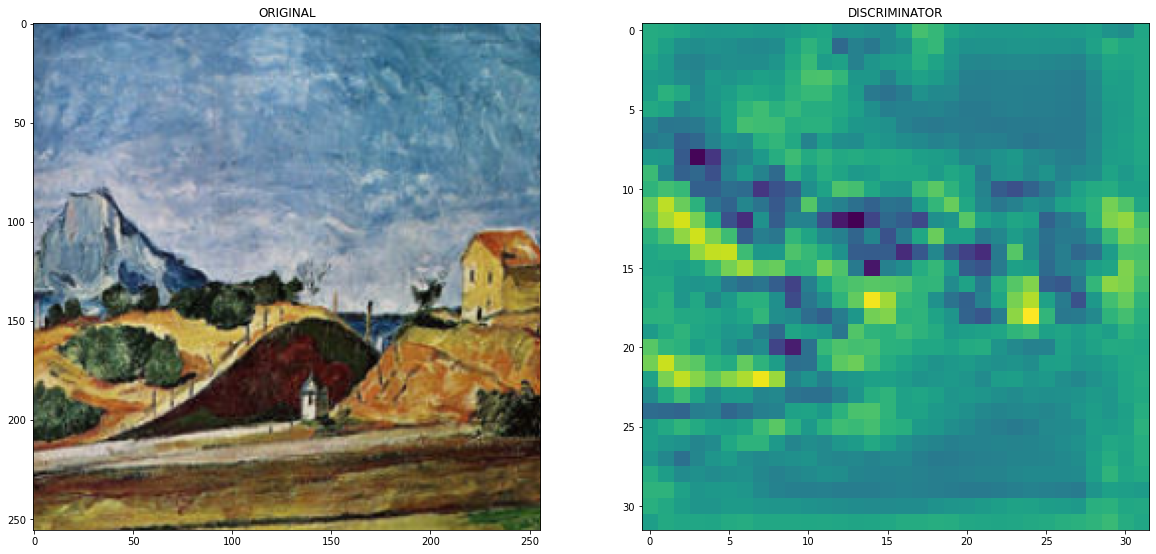

In [ ]:
for img in train_cezanne:
  plt.figure(figsize=(20,20))

  disc_result = np.array(disc_X(img,training=False))
  
  plt.subplot(1,2,1)
  plt.title('ORIGINAL')
  plt.imshow((img[0]+1)/2)
  plt.subplot(1,2,2)
  plt.title('DISCRIMINATOR')
  plt.imshow(disc_result[0].reshape(1,32,32)[0])

  break
